In [18]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle
import torch
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel


from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [19]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [20]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
# cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
#           'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']

cities = [ 'Bình Phước', 'An Giang','Quảng Ninh']

In [21]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [22]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [23]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [24]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [25]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [26]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [27]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [28]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,is_sklearn_model,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
      if is_sklearn_model == 1:
        train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ] #Fit size of the test by step
        test = df_eval[feature_list+[args.labels]].iloc[:,:].to_numpy()
        x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
        x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
        x_test,y_test = to_supervised(test, d_out=nstep, d_in=args.look_back )
        x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])

        model = model.fit(x_train,y_train)
        prediction = model.predict(x_test)
        
        print("🐹Len(prediction):",len(prediction))
        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values

        df_eval_pred_inverse = df_eval[-args.test_size:]
        df_eval_pred_inverse[labels]= prediction
        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))  
      else:
        x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
        y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

        x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
        y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

        model.fit(y_train, past_covariates = x_train)

        prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values
        df_eval[labels]= np.array(prediction._xa).squeeze()
        y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = mse**0.5
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print(f"mean_squared_error: {mse:.4f}")
  print(f"rmse: {rmse}")
  print(f"mape: {mape}")
  return model, y_true, y_pred, mse, mae, rmse, mape

In [29]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, is_sklearn_model ,nstep, model_name):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo, is_sklearn_model,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':prediction_inverse})
    df_compare_test_predict.plot()
    plt.legend()
    plt.title(f"{nstep}step_{type(model).__name__}_DF_{location}")

    folder_save_path = f"./predict_results/{model_name}/picture/"
    if not (os.path.isdir(folder_save_path)):
        os.makedirs(folder_save_path, exist_ok=True)
    plt.savefig(f"{folder_save_path}{nstep}step_{type(model).__name__}_DF_{location}_tkde.png", dpi=300)
    plt.show()

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [30]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [31]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  # display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1429.8694
rmse: 37.81361376225941
mape: 4.601103885443172


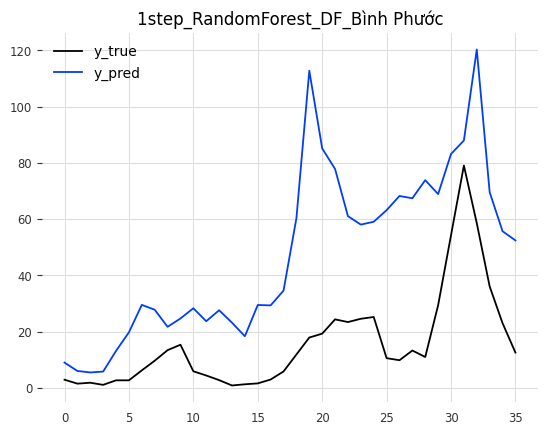

rmse,mae,mape,mse
37.81361376225941,31.53981789630103,4.601103885443172,1429.869385761334
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 67.3630
rmse: 8.207497425550274
mape: 1.2384668496922164


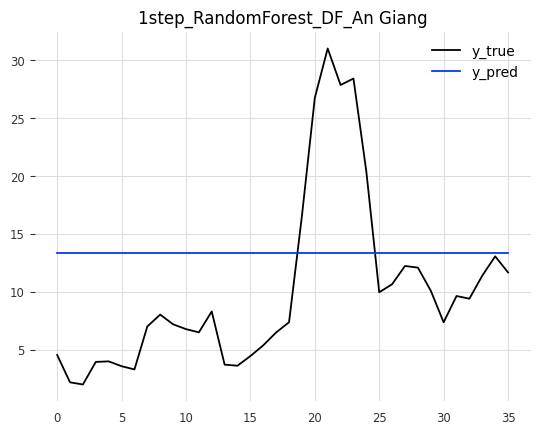

rmse,mae,mape,mse
8.207497425550274,7.079156636692573,1.2384668496922164,67.36301399041439
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 18.4115
rmse: 4.2908613003793015
mape: 4064134305401839.0


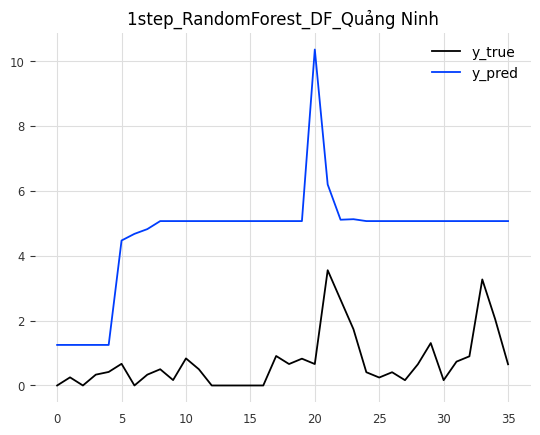

rmse,mae,mape,mse
4.2908613003793015,3.9603151550116937,4064134305401839.0,18.411490699092752
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 344.6558
rmse: 18.56490673652867
mape: 2.7082571251441263


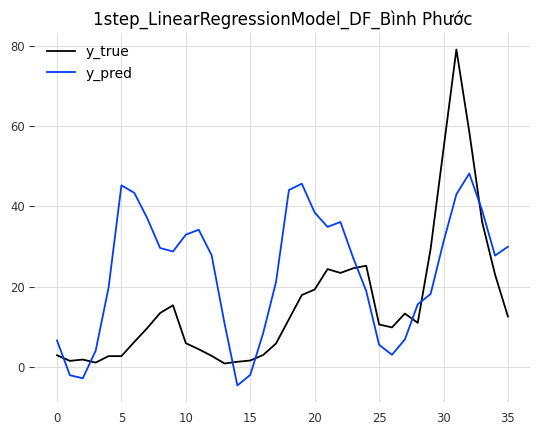

rmse,mae,mape,mse
18.56490673652867,14.732897170343952,2.7082571251441263,344.6557621360075
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 184.7688
rmse: 13.592970349615078
mape: 1.864611516690918


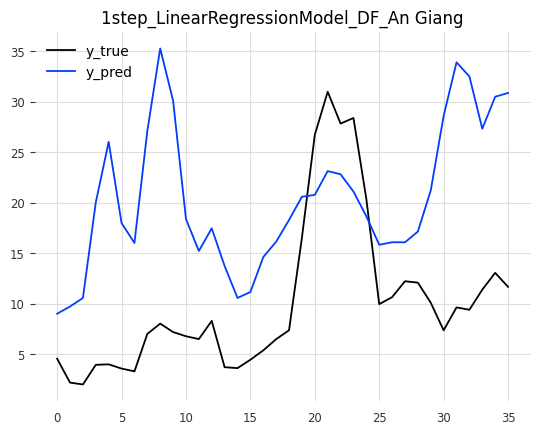

rmse,mae,mape,mse
13.592970349615078,11.768939375892574,1.864611516690918,184.76884292551466
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 4.4792
rmse: 2.116421256551339
mape: 1874874035755876.0


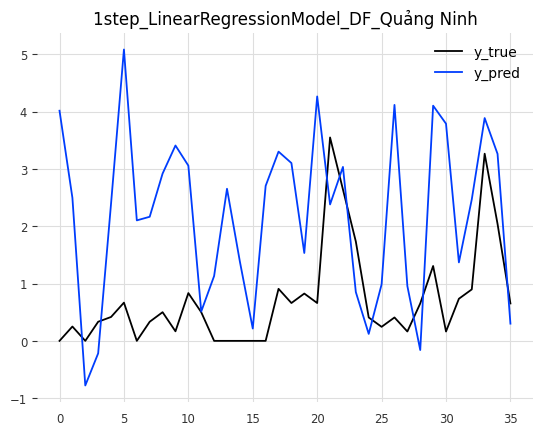

rmse,mae,mape,mse
2.116421256551339,1.7409935087793236,1874874035755876.0,4.479238935182349
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.009399403706478873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009399403706478873
[LightGBM] [Warning] feature_fraction is set=0.4495862018973762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4495862018973762
[LightGBM] [Warning] lambda_l1 is set=0.009399403706478873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009399403706478873
[LightGBM] [Warning] feature_fraction is set=0.4495862018973762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4495862018973762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 200, number 

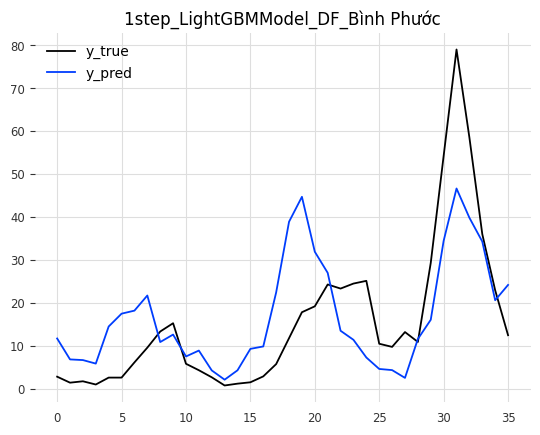

rmse,mae,mape,mse
12.631378305823816,9.90015771329273,1.5091677871968883,159.55171790483655
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.8226542857217595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8226542857217595
[LightGBM] [Warning] feature_fraction is set=0.1136674950839723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1136674950839723
[LightGBM] [Warning] lambda_l1 is set=0.8226542857217595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8226542857217595
[LightGBM] [Warning] feature_fraction is set=0.1136674950839723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1136674950839723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 12
[LightGBM] [Info] Sta

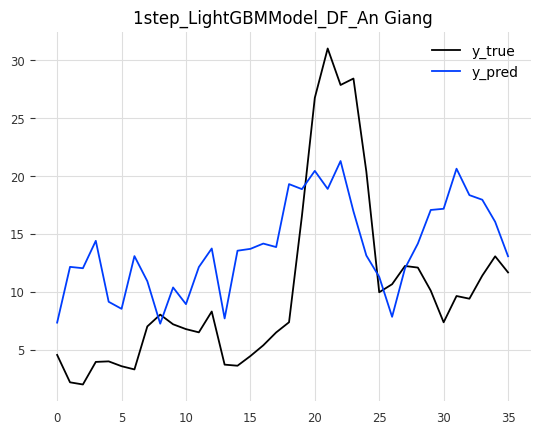

rmse,mae,mape,mse
7.190295455471646,6.263945600553071,1.0868475002589117,51.7003487369762
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=9.559653939887886e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.559653939887886e-06
[LightGBM] [Warning] feature_fraction is set=0.2644382187060457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2644382187060457
[LightGBM] [Warning] lambda_l1 is set=9.559653939887886e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.559653939887886e-06
[LightGBM] [Warning] feature_fraction is set=0.2644382187060457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2644382187060457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 12
[LightGBM

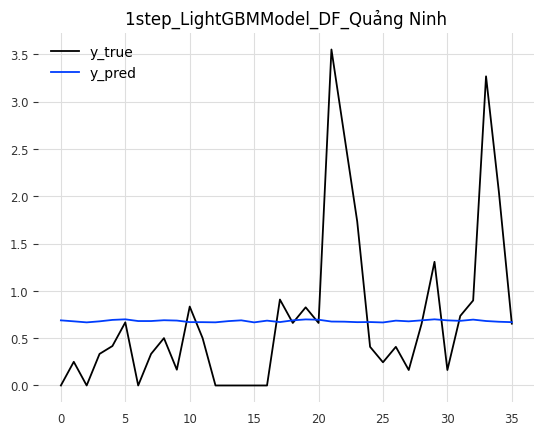

rmse,mae,mape,mse
0.8773550647790872,0.5858278211679943,678373288147595.2,0.7697519096935164
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 232.6702
rmse: 15.253529318347061
mape: 2.632376520573179


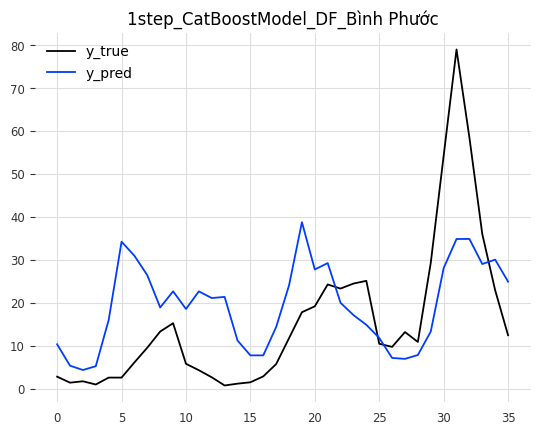

rmse,mae,mape,mse
15.253529318347061,12.092632889595555,2.632376520573179,232.67015666567335
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 157.7088
rmse: 12.55821572581793
mape: 1.49871484017707


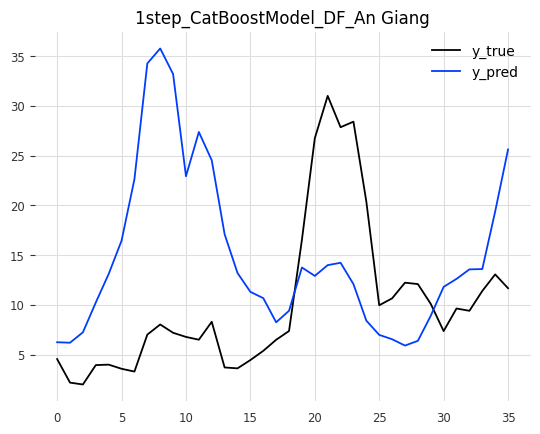

rmse,mae,mape,mse
12.55821572581793,10.043954112923576,1.49871484017707,157.7087822161808
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1.0278
rmse: 1.0138286512940398
mape: 310804129946901.7


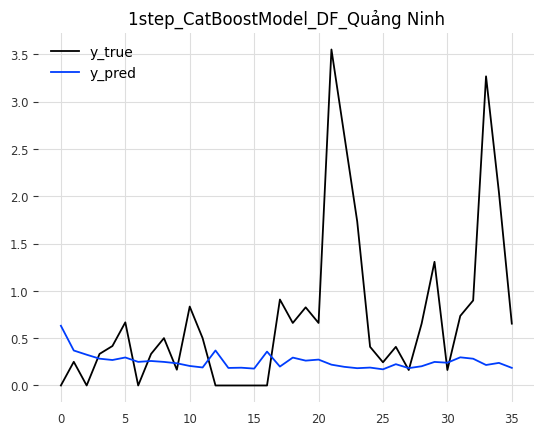

rmse,mae,mape,mse
1.0138286512940398,0.619704905546117,310804129946901.7,1.0278485341846917
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 4951.2486
rmse: 70.36510907267701
mape: 8.043089668755885


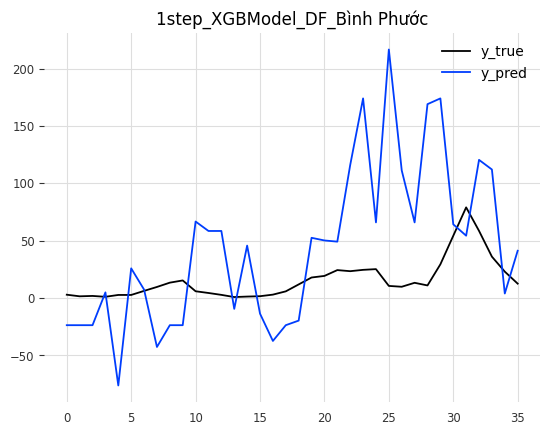

rmse,mae,mape,mse
70.36510907267701,53.08699390404981,8.043089668755885,4951.248574809732
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1052.6362
rmse: 32.44435536364024
mape: 3.831969991196966


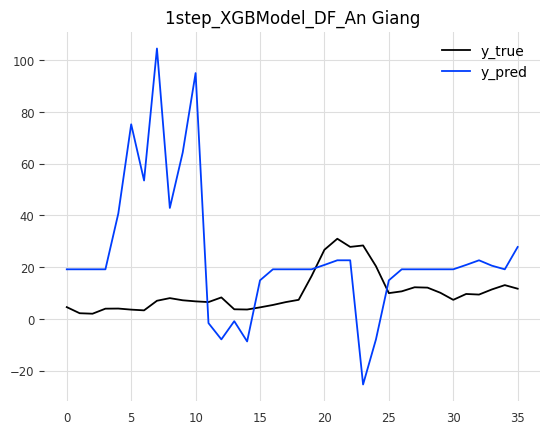

rmse,mae,mape,mse
32.44435536364024,22.199818214297075,3.831969991196966,1052.6361949621712
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 412.4936
rmse: 20.309938136846082
mape: 1.0491335231488936e+16


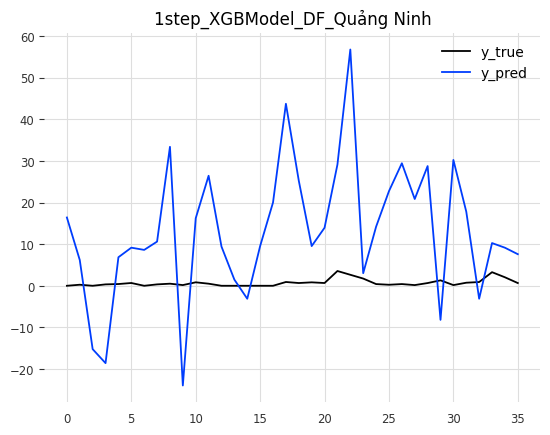

rmse,mae,mape,mse
20.309938136846082,16.63011628390002,1.0491335231488936e+16,412.49358712251484
✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 412.9567
rmse: 20.321334914452944
mape: 3.7675242251080423


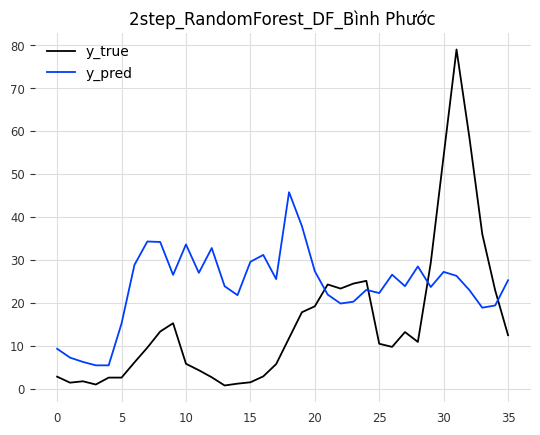

rmse,mae,mape,mse
20.321334914452944,16.721371947791358,3.7675242251080423,412.9566527053642
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 199.6016
rmse: 14.128043622773063
mape: 1.9987079536875538


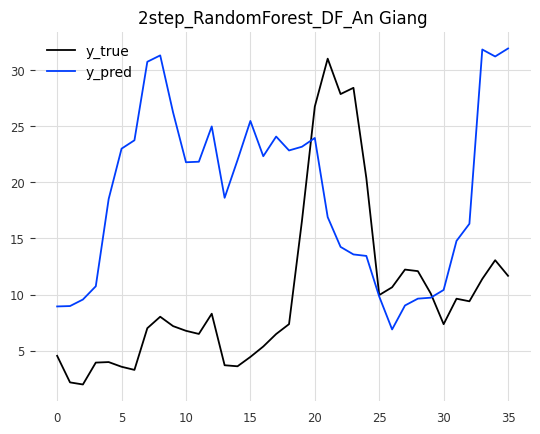

rmse,mae,mape,mse
14.128043622773063,12.217666493784735,1.9987079536875538,199.6016166069786
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 6.2961
rmse: 2.509202491357231
mape: 1242020649389814.5


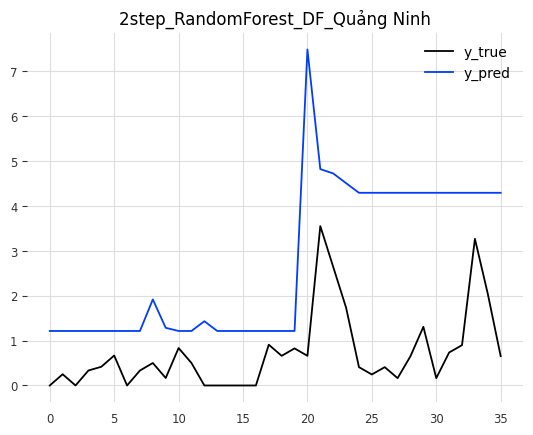

rmse,mae,mape,mse
2.509202491357231,2.0102190752608946,1242020649389814.5,6.296097142633336
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 321.4726
rmse: 17.929656829387422
mape: 3.0179503894840525


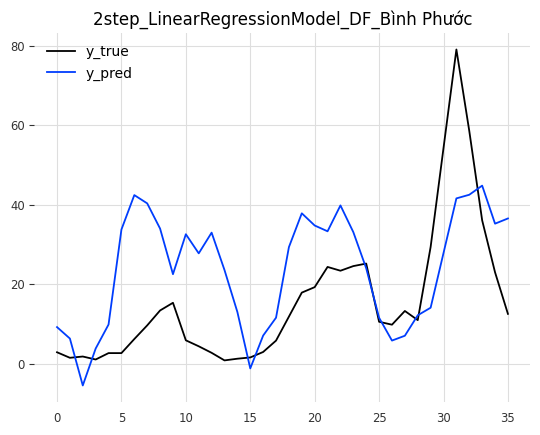

rmse,mae,mape,mse
17.929656829387422,14.50540786339661,3.0179503894840525,321.472594019599
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 195.5684
rmse: 13.984577150904904
mape: 2.0226315379199753


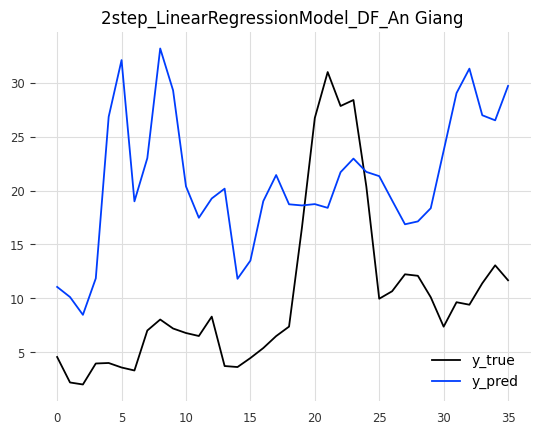

rmse,mae,mape,mse
13.984577150904904,12.402518518473059,2.0226315379199753,195.56839808961155
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 4.4467
rmse: 2.1087279486751256
mape: 1696288200135148.2


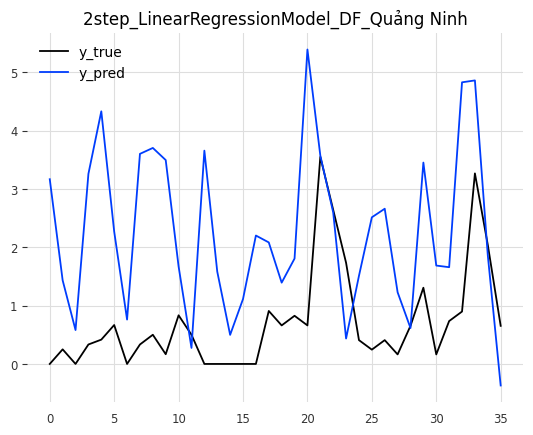

rmse,mae,mape,mse
2.1087279486751256,1.6963354824755699,1696288200135148.2,4.446733561523604
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.0001564671508840216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001564671508840216
[LightGBM] [Warning] feature_fraction is set=0.3629865440332562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3629865440332562
[LightGBM] [Warning] lambda_l1 is set=0.0001564671508840216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001564671508840216
[LightGBM] [Warning] feature_fraction is set=0.3629865440332562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3629865440332562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 199, nu

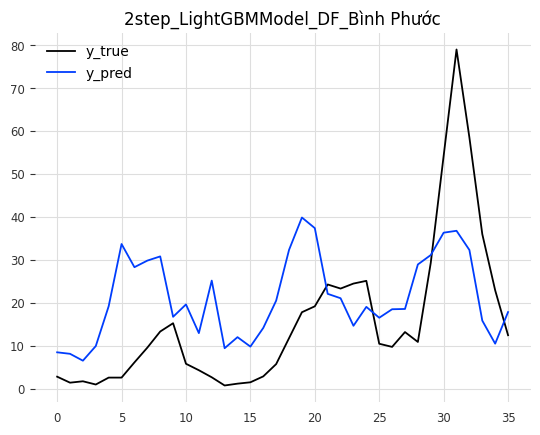

rmse,mae,mape,mse
16.01765875392144,13.314573521726587,2.6727165525925685,256.5653919570762
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.007230799237788472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007230799237788472
[LightGBM] [Warning] feature_fraction is set=0.1081650265757642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1081650265757642
[LightGBM] [Warning] lambda_l1 is set=0.007230799237788472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007230799237788472
[LightGBM] [Warning] feature_fraction is set=0.1081650265757642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1081650265757642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 13
[LightGBM] [I

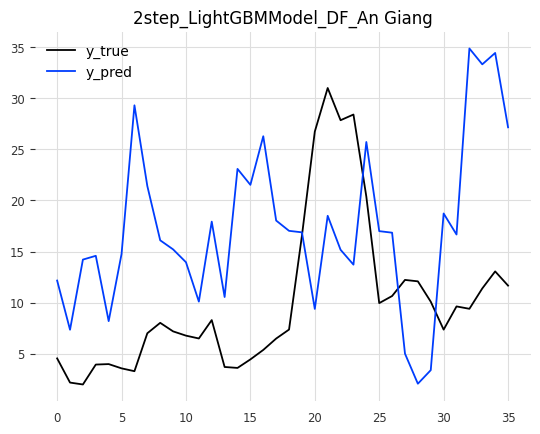

rmse,mae,mape,mse
13.116237585039269,11.55958021161999,1.8197812407197422,172.03568838719673
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.001185061688239735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001185061688239735
[LightGBM] [Warning] feature_fraction is set=0.5163922340983108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163922340983108
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=0.001185061688239735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001185061688239735
[LightGBM] [Warning] feature_fraction is set=0.5163922340983108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5163922340983108
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the 

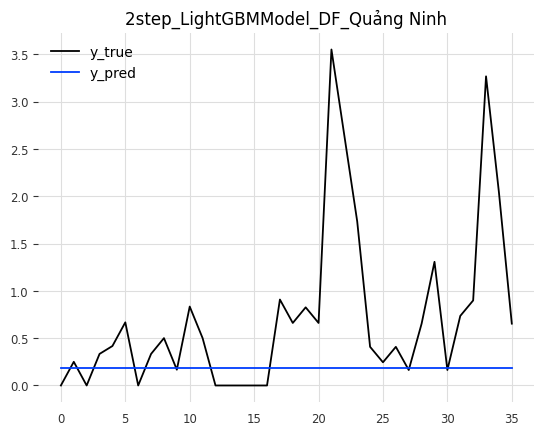

rmse,mae,mape,mse
1.027691472586211,0.6217494453409337,182612677389172.16,1.056149762826415
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 242.8345
rmse: 15.583147823684627
mape: 2.464689612801781


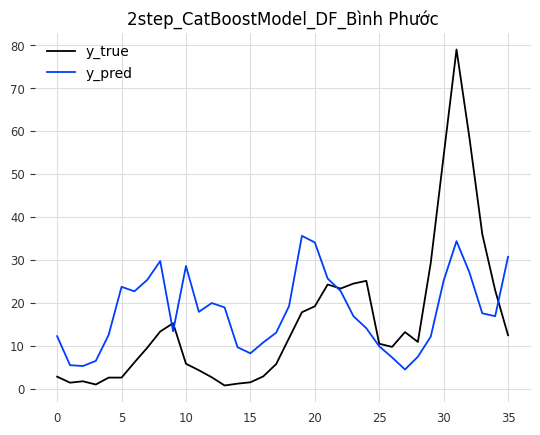

rmse,mae,mape,mse
15.583147823684627,12.421575169529733,2.464689612801781,242.83449609480692
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 71.0224
rmse: 8.427478847040588
mape: 1.1383021310823673


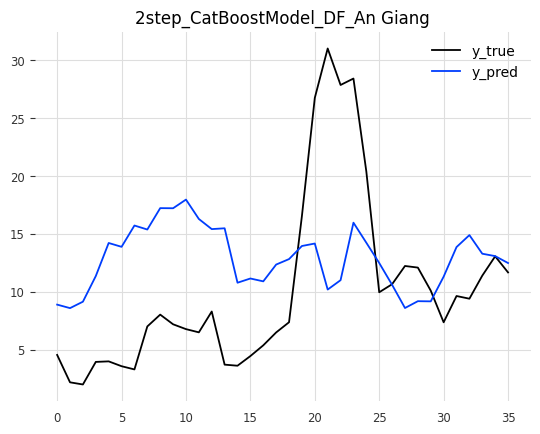

rmse,mae,mape,mse
8.427478847040588,7.060230010419565,1.1383021310823673,71.02239971731655
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1.0492
rmse: 1.024298229998165
mape: 311310242493167.75


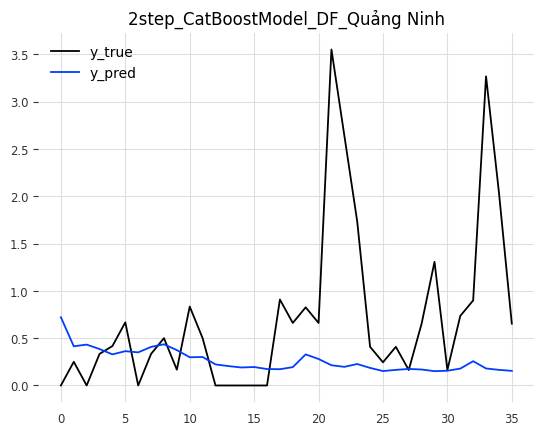

rmse,mae,mape,mse
1.024298229998165,0.6229012997804885,311310242493167.75,1.049186863977374
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2460.8378
rmse: 49.60683171139254
mape: 6.348124609539166


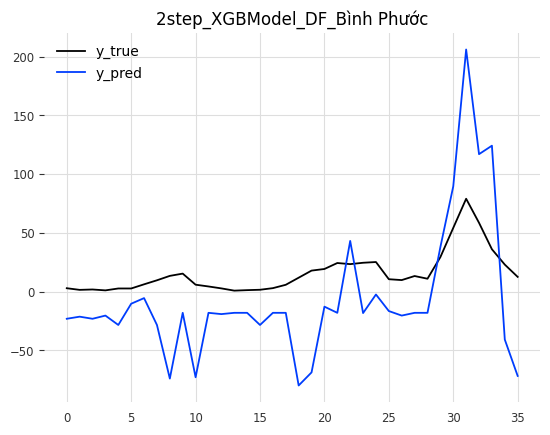

rmse,mae,mape,mse
49.60683171139254,40.89236054524113,6.348124609539166,2460.83775244242
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1916.6461
rmse: 43.77951661911574
mape: 6.443460109785577


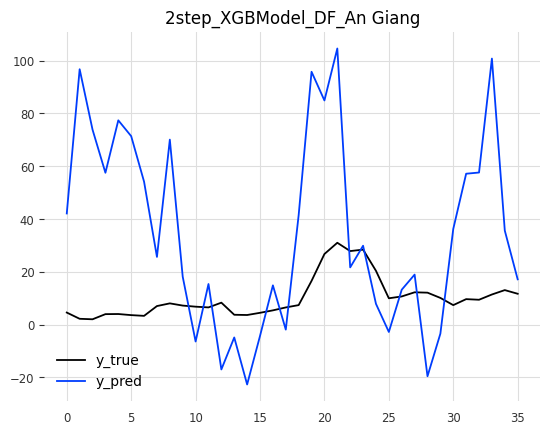

rmse,mae,mape,mse
43.77951661911574,34.02859574003378,6.443460109785577,1916.646075403431
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 27.4061
rmse: 5.2350788537227775
mape: 4400386990851418.5


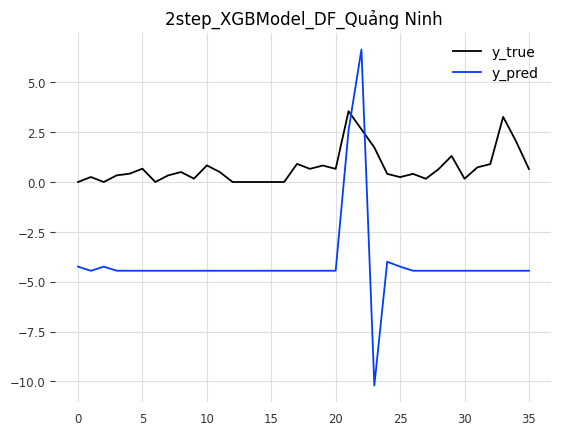

rmse,mae,mape,mse
5.2350788537227775,5.01735840430519,4400386990851418.5,27.406050604695388
✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 278.8195
rmse: 16.69788809463023
mape: 3.3491073482260676


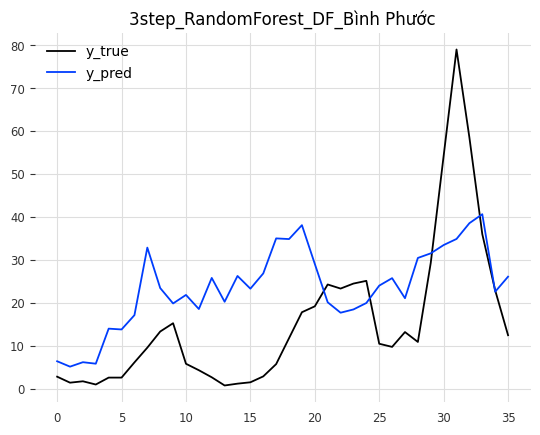

rmse,mae,mape,mse
16.69788809463023,13.828107102395771,3.3491073482260676,278.81946682079393
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 222.2140
rmse: 14.906844302511843
mape: 2.0607490098680623


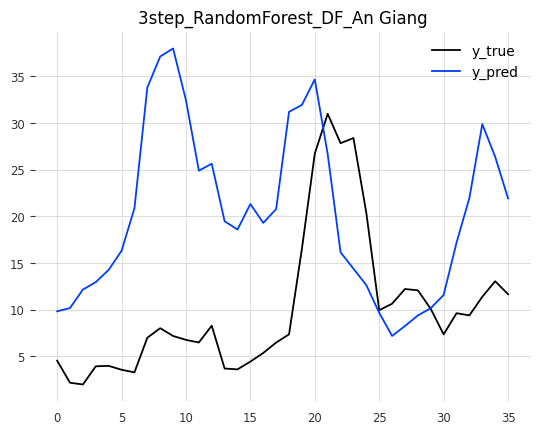

rmse,mae,mape,mse
14.906844302511843,12.750565546111972,2.0607490098680623,222.2140070593298
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 0.7795
rmse: 0.8828704910174835
mape: 832052538245441.1


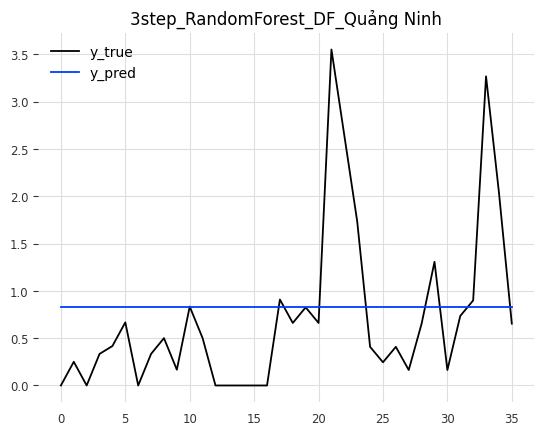

rmse,mae,mape,mse
0.8828704910174835,0.650013073546051,832052538245441.1,0.7794603039094524
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 302.4767
rmse: 17.391858426764507
mape: 2.861083927420058


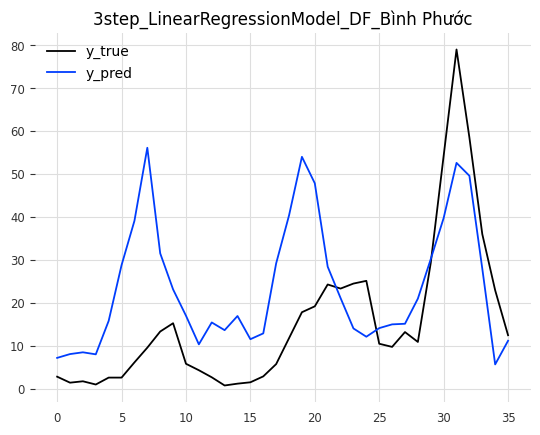

rmse,mae,mape,mse
17.391858426764507,13.69629602550743,2.861083927420058,302.47673953661956
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 152.3325
rmse: 12.342304492031591
mape: 1.788989555655957


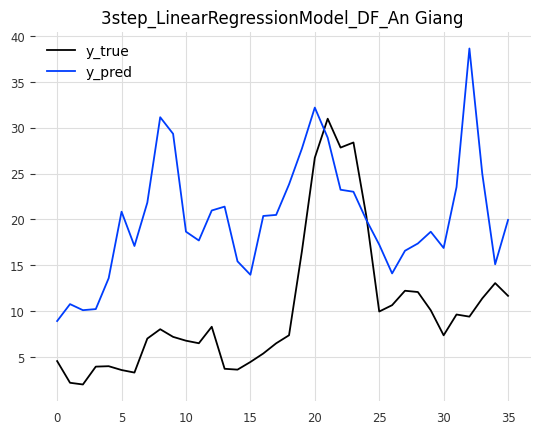

rmse,mae,mape,mse
12.342304492031591,10.645827807948233,1.788989555655957,152.3324801740232
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2.8666
rmse: 1.6930958249968109
mape: 866593664582826.9


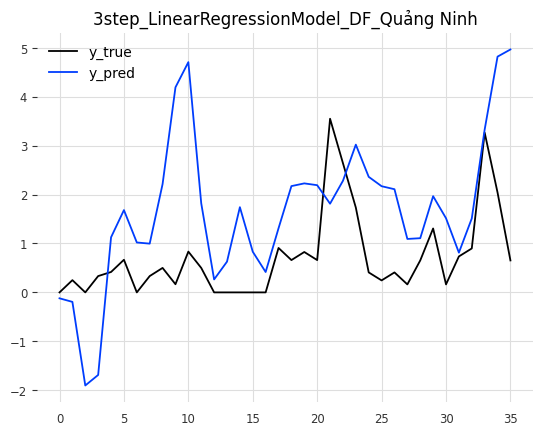

rmse,mae,mape,mse
1.6930958249968109,1.3267914792161895,866593664582826.9,2.8665734726216314
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=3.311263429523544e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311263429523544e-06
[LightGBM] [Warning] feature_fraction is set=0.2344981948621712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2344981948621712
[LightGBM] [Warning] lambda_l1 is set=3.311263429523544e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.311263429523544e-06
[LightGBM] [Warning] feature_fraction is set=0.2344981948621712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2344981948621712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 198, nu

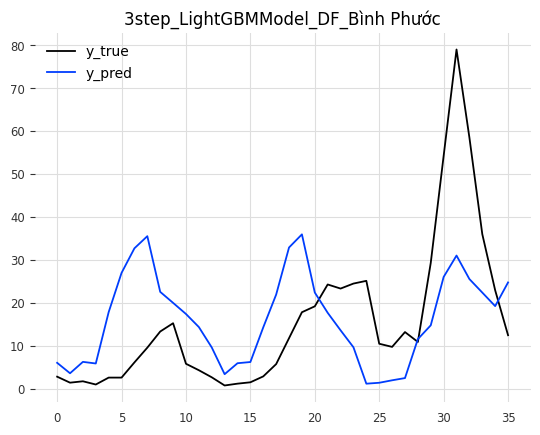

rmse,mae,mape,mse
16.50826253889422,13.002311786265274,1.8605700026723488,272.5227320530582
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=3.693131535253421e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.693131535253421e-05
[LightGBM] [Warning] feature_fraction is set=0.4846831665762428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4846831665762428
[LightGBM] [Warning] lambda_l1 is set=3.693131535253421e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.693131535253421e-05
[LightGBM] [Warning] feature_fraction is set=0.4846831665762428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4846831665762428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 14
[LightGBM

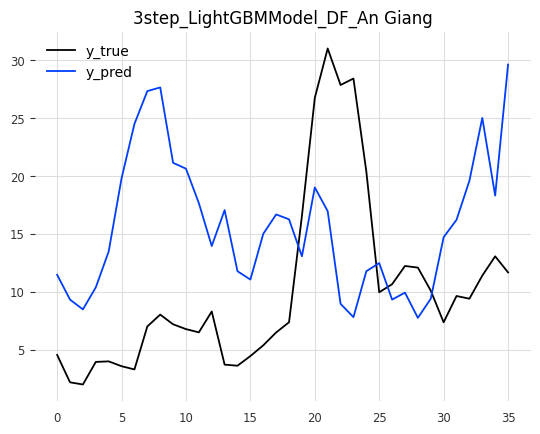

rmse,mae,mape,mse
11.52179636778018,10.016172997991406,1.564748260046759,132.75179154059254
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=0.0004180348594781516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004180348594781516
[LightGBM] [Warning] feature_fraction is set=0.6537437916007931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6537437916007931
[LightGBM] [Warning] lambda_l1 is set=0.0004180348594781516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004180348594781516
[LightGBM] [Warning] feature_fraction is set=0.6537437916007931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6537437916007931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 14
[LightG

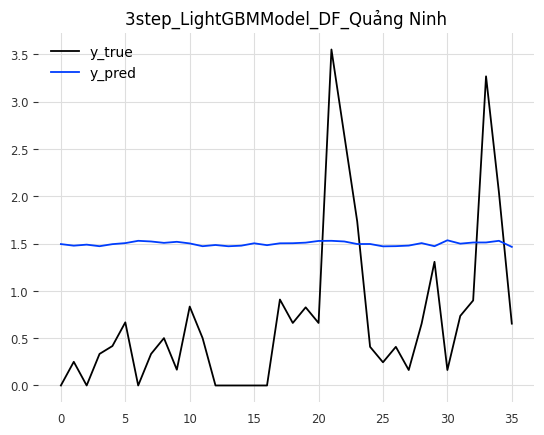

rmse,mae,mape,mse
1.1653821926076813,1.0913438262110138,1492071911493409.0,1.3581156548470865
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 241.9258
rmse: 15.55396525719335
mape: 1.7837440287825237


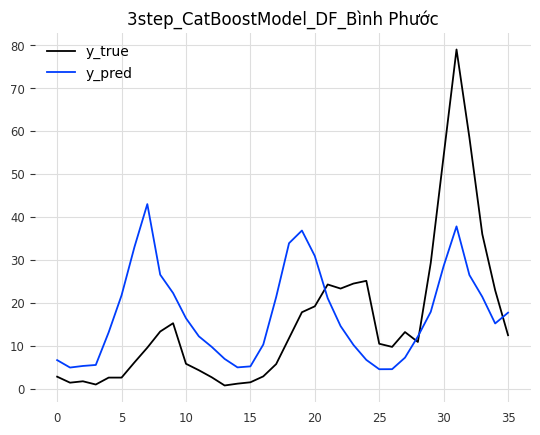

rmse,mae,mape,mse
15.55396525719335,12.262653197540667,1.7837440287825237,241.92583522197785
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 63.4879
rmse: 7.967931115205716
mape: 1.0854283069071364


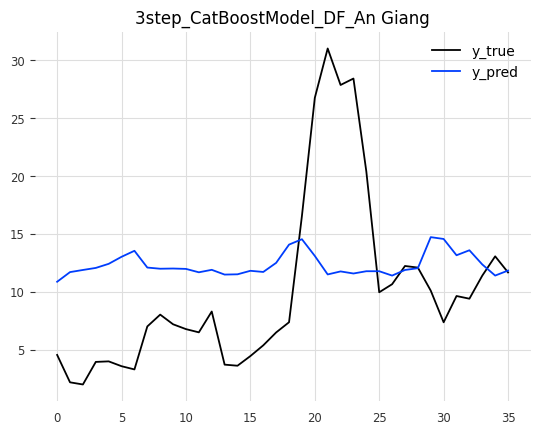

rmse,mae,mape,mse
7.967931115205716,6.4932477316383235,1.0854283069071364,63.487926256663414
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1.0115
rmse: 1.0057311129408097
mape: 290938225142938.25


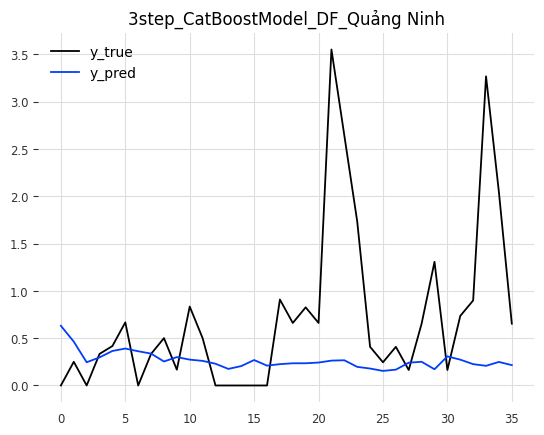

rmse,mae,mape,mse
1.0057311129408097,0.6153203038777197,290938225142938.25,1.0114950715371598
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2583.7218
rmse: 50.83032372309633
mape: 6.013958792538201


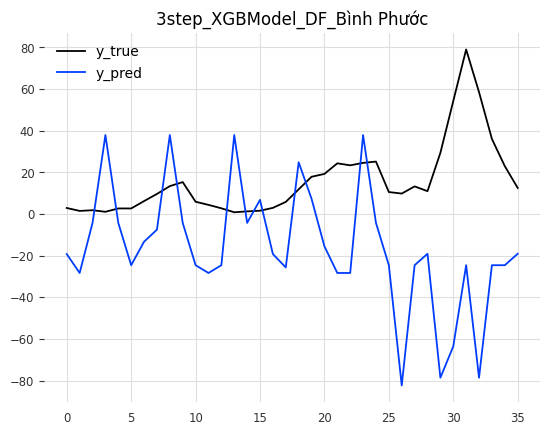

rmse,mae,mape,mse
50.83032372309633,39.14972594051404,6.013958792538201,2583.7218097947693
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 1994.4614
rmse: 44.65939283012492
mape: 5.7112491528461184


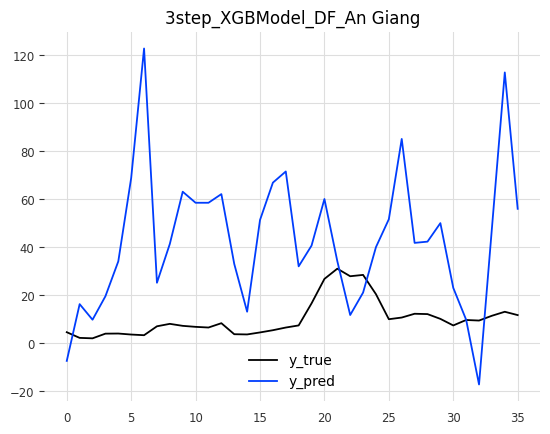

rmse,mae,mape,mse
44.65939283012492,36.3044755885307,5.7112491528461184,1994.4613679554136
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 33.1853
rmse: 5.760671986361972
mape: 4937782950423550.0


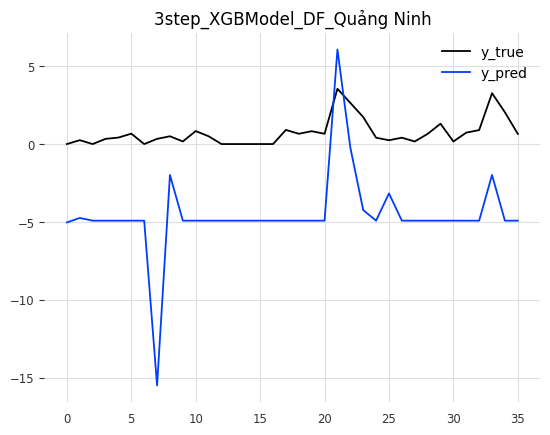

rmse,mae,mape,mse
5.760671986361972,5.405838700602342,4937782950423550.0,33.185341734455584
✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 378.7948
rmse: 19.46265226518275
mape: 1.8793042947807268


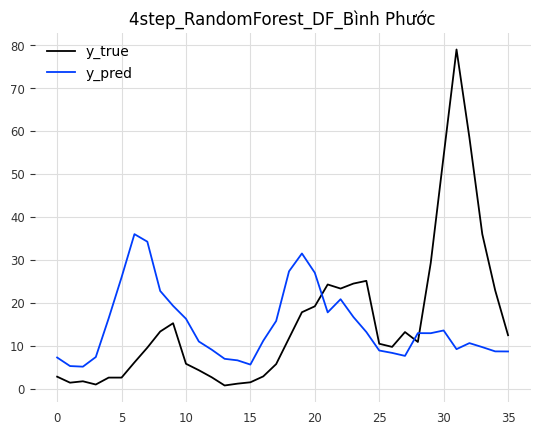

rmse,mae,mape,mse
19.46265226518275,13.224668604326038,1.8793042947807268,378.7948331954232
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 106.6688
rmse: 10.328060050057273
mape: 1.3987787174681914


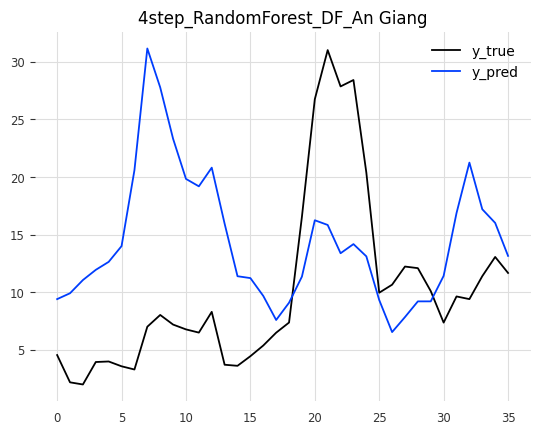

rmse,mae,mape,mse
10.328060050057273,8.643901116784381,1.3987787174681914,106.66882439758902
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 80.9070
rmse: 8.994833626645221
mape: 8554493696308060.0


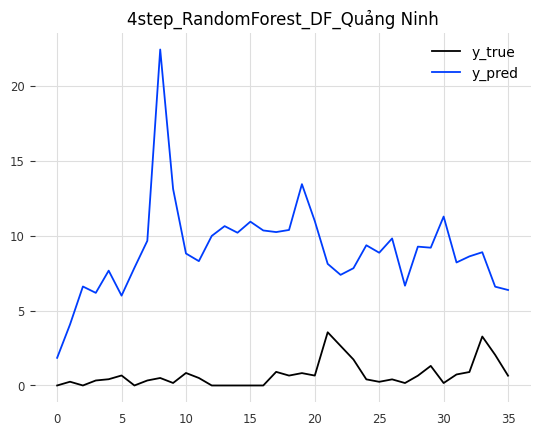

rmse,mae,mape,mse
8.994833626645221,8.33548713792409,8554493696308060.0,80.90703197102762
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 306.0556
rmse: 17.494443556789793
mape: 3.2493149928349467


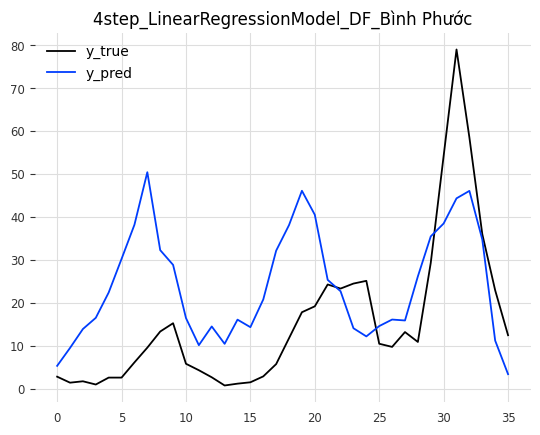

rmse,mae,mape,mse
17.494443556789793,14.484846373187708,3.2493149928349467,306.05555536170397
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 110.1778
rmse: 10.496559853154205
mape: 1.5245214216082605


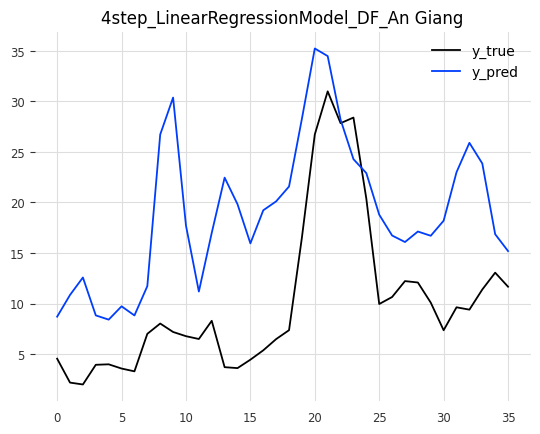

rmse,mae,mape,mse
10.496559853154205,9.033686158145969,1.5245214216082605,110.17776875084863
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
mean_squared_error: 2.5324
rmse: 1.5913422509770252
mape: 1610578261657143.5


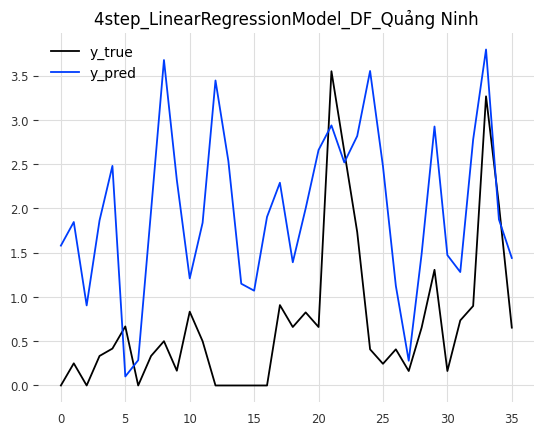

rmse,mae,mape,mse
1.5913422509770252,1.341556146740839,1610578261657143.5,2.5323701597446258
✨✨✨✨✨✨✨✨LightGBMModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=3.464376164940218e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.464376164940218e-07
[LightGBM] [Warning] feature_fraction is set=0.1405980415236388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1405980415236388
[LightGBM] [Warning] lambda_l1 is set=3.464376164940218e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.464376164940218e-07
[LightGBM] [Warning] feature_fraction is set=0.1405980415236388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1405980415236388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 197, nu

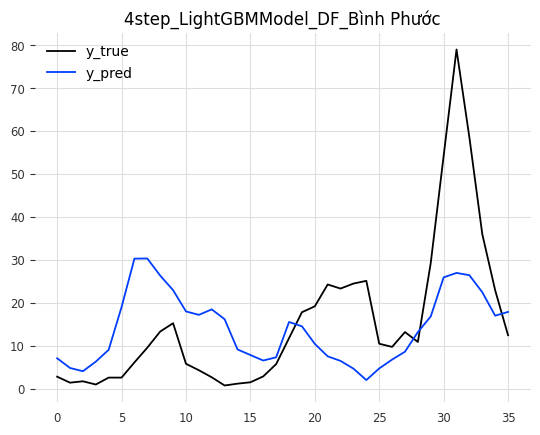

rmse,mae,mape,mse
15.92432760872084,12.143755371437296,2.096236569404356,253.58420978986882
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=3.653261613909862e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.653261613909862e-05
[LightGBM] [Warning] feature_fraction is set=0.4693766687861697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4693766687861697
[LightGBM] [Warning] lambda_l1 is set=3.653261613909862e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.653261613909862e-05
[LightGBM] [Warning] feature_fraction is set=0.4693766687861697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4693766687861697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 15
[LightGBM

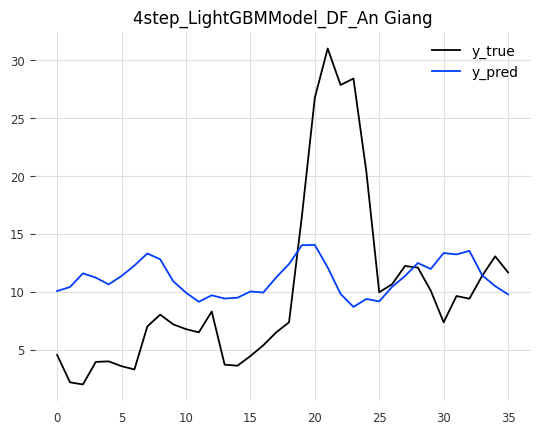

rmse,mae,mape,mse
7.692743392658444,5.9067101500858366,0.9286445939681194,59.17830090529014
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
[LightGBM] [Warning] lambda_l1 is set=1.487222567629681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.487222567629681
[LightGBM] [Warning] feature_fraction is set=0.100834039611563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.100834039611563
[LightGBM] [Warning] lambda_l1 is set=1.487222567629681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.487222567629681
[LightGBM] [Warning] feature_fraction is set=0.100834039611563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.100834039611563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 15
[LightGBM] [Warning] No fur

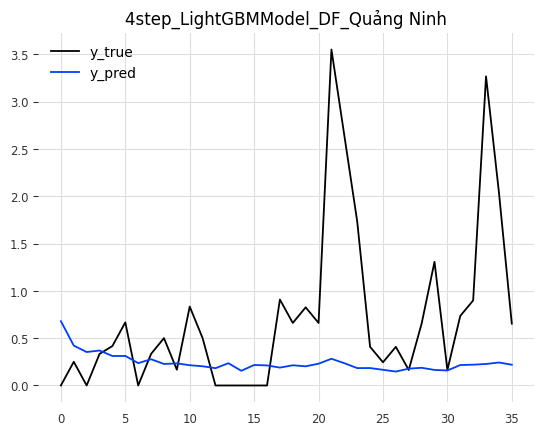

rmse,mae,mape,mse
1.0106112539013277,0.6209819333476373,283930488688320.7,1.0213351065120138
✨✨✨✨✨✨✨✨CatBoostModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


KeyboardInterrupt: 

In [33]:
model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
     "LightGBMModel",
     "CatBoostModel",
     "XGBModel",
    # "PoissonRegressor",
    # "SVMRBF"
]

for nstep in range(1,args.n_predicted_period_months+1):
# for nstep in range(1,2):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
            is_sklearn_model = 0
            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state),
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state))
            elif model_name == "CatBoostModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    opt_quantitles = df_hyper_params['quantiles'].values[0]
                    if opt_quantitles == "IsNone":
                        quantitles = None
                    else:
                        quantitles = df_hyper_params['quantiles'].values[0].split(',')
                    model = CatBoostModel(
                                            lags=int(lags),
                                            lags_past_covariates=lags_past_covariates, 
                                            learning_rate=float(learning_rate),
                                            n_estimators= int(n_estimators),
                                            max_depth=int(max_depth), 
                                            output_chunk_length = int(output_chunk_length),
                                            likelihood = likelihood,
                                            # quantiles = float(quantiles), #None or float
                                            bagging_temperature = float(bagging_temperature),
                                            # border_count = int(border_count),
                                            l2_leaf_reg = float(l2_leaf_reg),
                                            random_strength = float(random_strength),
                                            random_state=int(random_state))
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = 1
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    model = LightGBMModel(
                        lags =int(lags),
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = int(output_chunk_length),
                        multi_models = bool(multi_models),
                        likelihood = likelihood,
                        num_leaves = int(num_leaves),
                        learning_rate = float(learning_rate),
                        feature_fraction = float(feature_fraction),
                        min_child_samples = int(min_child_samples),
                        lambda_l1 = float(lambda_l1),
                    )
            elif model_name == 'SVMRBF':
                    max_iter = df_hyper_params['max_iter'].values[0]
                    epsilon = df_hyper_params['epsilon'].values[0],
                    model = SVR(
                        max_iter = max_iter,
                        kernel = 'rbf',
                        epsilon = epsilon[0]
                    )
                    is_sklearn_model = 1
            elif model_name == "PoissonRegressor":
                    max_iter = df_hyper_params['max_iter'].values[0]
                    alpha = df_hyper_params['alpha'].values[0],
                    model = PoissonRegressor(
                        max_iter = max_iter,
                        fit_intercept = False,
                        alpha = alpha[0]
                    )
                    is_sklearn_model = 1        
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo,is_sklearn_model = is_sklearn_model, nstep = nstep,model_name = model_name)
             
            folder_save_rs_path = f"./predict_results/{model_name}/"
            folder_save_model_path = f"./trained_models/{model_name}/"
            if not (os.path.isdir(folder_save_rs_path)):
                os.makedirs(folder_save_rs_path, exist_ok=True)
            if not (os.path.isdir(folder_save_model_path)):
                os.makedirs(folder_save_model_path, exist_ok=True)
            df.to_excel(f"{folder_save_rs_path}0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"{folder_save_model_path}{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))